In [1]:
import pandas as pd
import numpy as np
import csv
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
csv2 = pd.read_csv("2agosto -dic 2021.csv",quoting=csv.QUOTE_NONE)

In [3]:
csv2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3178051 entries, 0 to 3178050
Data columns (total 19 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   "MAC"                    object
 1   "weekday"                object
 2   "fecha_servidor"         object
 3   "fecha_esp32"            object
 4   "voltaje"                object
 5   "corriente"              object
 6   "potencia"               object
 7   "frecuencia"             object
 8   "energia"                object
 9   "fp"                     object
 10  "ESP32_temp"             object
 11  "WORKSTATION_CPU"        object
 12  "WORKSTATION_CPU_POWER"  object
 13  "WORKSTATION_CPU_TEMP"   object
 14  "WORKSTATION_GPU"        object
 15  "WORKSTATION_GPU_POWER"  object
 16  "WORKSTATION_GPU_TEMP"   object
 17  "WORKSTATION_RAM"        object
 18  "WORKSTATION_RAM_POWER"  object
dtypes: object(19)
memory usage: 460.7+ MB


In [4]:
def data_preprocessing(df):

    df.columns = df.columns.str.replace('"','')
    df.replace({r'"': ''}, regex=True, inplace=True)

    df = df.drop(['MAC','fecha_servidor'],axis=1)
    
    df['fecha_esp32'] = pd.to_datetime(df['fecha_esp32'], format='%Y-%m-%d %H:%M:%S')
    df[["voltaje","corriente","potencia","frecuencia","energia","fp","ESP32_temp","WORKSTATION_CPU",
        "WORKSTATION_CPU_POWER","WORKSTATION_CPU_TEMP","WORKSTATION_GPU","WORKSTATION_GPU_POWER","WORKSTATION_GPU_TEMP",
        "WORKSTATION_RAM","WORKSTATION_RAM_POWER"]]=df[["voltaje","corriente","potencia","frecuencia","energia","fp","ESP32_temp","WORKSTATION_CPU",
        "WORKSTATION_CPU_POWER","WORKSTATION_CPU_TEMP","WORKSTATION_GPU","WORKSTATION_GPU_POWER","WORKSTATION_GPU_TEMP",
        "WORKSTATION_RAM","WORKSTATION_RAM_POWER"]].astype(float)
    df['weekday']=df['weekday'].astype(int)
    
    df['total_utilization'] = (df['WORKSTATION_CPU'] + df['WORKSTATION_GPU'] + df['WORKSTATION_RAM'])
    df['hour'] = pd.to_datetime(df['fecha_esp32'], format='%Y-%m-%d %H:%M:%S').dt.hour.astype('int8')
    df['is_weekend'] = (df['weekday'] >= 5).astype('int8')
    
    return df
df = data_preprocessing(csv2)

Text(0.5, 1.0, 'Proportion of Sleeping and Working States based on CPU Power')

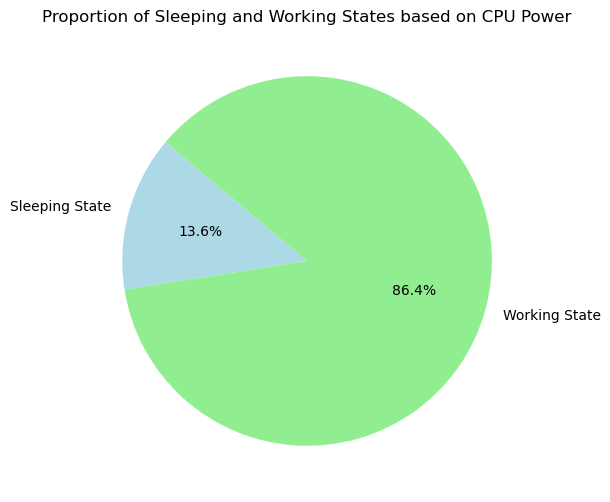

In [5]:
#Visualize the proportion of sleeping and working states based on CPU Power
CPU_Pow = df['WORKSTATION_CPU_POWER']
Sleeping_Count = CPU_Pow[CPU_Pow == 0].count()
Working_Count = CPU_Pow[CPU_Pow != 0].count()

labels = ['Sleeping State', 'Working State']
sizes = [Sleeping_Count, Working_Count]
colors = ['lightblue', 'lightgreen']

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Sleeping and Working States based on CPU Power')

In [6]:
def create_efficiency_labels(df):

    # Use zero CPU power consumption as the criterion for determining the sleep state
    sleep_condition = (df['WORKSTATION_CPU_POWER'] == 0)

    efficiency_score = (df['WORKSTATION_CPU'] + df['WORKSTATION_GPU']) / (df['potencia'] + 1)
    low_threshold = float(efficiency_score.quantile(0.33))
    high_threshold = float(efficiency_score.quantile(0.67))
    
    print(f"Low: {low_threshold:.4f}, High: {high_threshold:.4f}")
    
    df['efficiency_class'] = 'SLEEP'

    active_mask = ~sleep_condition
    efficiency_score_active = (
        df.loc[active_mask, 'WORKSTATION_CPU'] + 
        df.loc[active_mask, 'WORKSTATION_GPU']
    ) / (df.loc[active_mask, 'potencia'] + 1)
    
    low_efficiency_mask = (efficiency_score_active <= low_threshold)
    medium_efficiency_mask = ((efficiency_score_active > low_threshold) & (efficiency_score_active <= high_threshold))
    high_efficiency_mask = (efficiency_score_active > high_threshold)

    active_indices = df[active_mask].index
    df.loc[active_indices[low_efficiency_mask], 'efficiency_class'] = 'Low_Efficiency'
    df.loc[active_indices[medium_efficiency_mask], 'efficiency_class'] = 'Medium_Efficiency'
    df.loc[active_indices[high_efficiency_mask], 'efficiency_class'] = 'High_Efficiency'

    return df
df = create_efficiency_labels(df)

Low: 0.0406, High: 0.0517


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3178051 entries, 0 to 3178050
Data columns (total 21 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   weekday                int32         
 1   fecha_esp32            datetime64[ns]
 2   voltaje                float64       
 3   corriente              float64       
 4   potencia               float64       
 5   frecuencia             float64       
 6   energia                float64       
 7   fp                     float64       
 8   ESP32_temp             float64       
 9   WORKSTATION_CPU        float64       
 10  WORKSTATION_CPU_POWER  float64       
 11  WORKSTATION_CPU_TEMP   float64       
 12  WORKSTATION_GPU        float64       
 13  WORKSTATION_GPU_POWER  float64       
 14  WORKSTATION_GPU_TEMP   float64       
 15  WORKSTATION_RAM        float64       
 16  WORKSTATION_RAM_POWER  float64       
 17  total_utilization      float64       
 18  hour                  

In [8]:
active_mask = df['efficiency_class'] != 'SLEEP'
df_active = df[active_mask].copy()

print(f"Total Count of Active Data: {len(df_active)}")
print(f"Distribution of Active Types:\n{df_active['efficiency_class'].value_counts()}")

features = [
    'voltaje', 'corriente', 'potencia', 'frecuencia', 'energia',
    'ESP32_temp', 'WORKSTATION_CPU_TEMP', 
    'WORKSTATION_GPU', 'WORKSTATION_GPU_TEMP',
    'WORKSTATION_RAM', 'hour', 'is_weekend',
]

X = df_active[features]
y = df_active['efficiency_class']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Features: {len(features)}")
print(f"Total Count: {len(X)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print(f"Train Size: {X_train.shape}")
print(f"Test size: {X_test.shape}")


Total Count of Active Data: 2746226
Distribution of Active Types:
efficiency_class
Medium_Efficiency    1080490
High_Efficiency      1048683
Low_Efficiency        617053
Name: count, dtype: int64
Features: 12
Total Count: 2746226
Train Size: (1922358, 12)
Test size: (823868, 12)


In [9]:
#Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"Accuracy: {accuracy_rf:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Accuracy: 0.7139
Classification Report:
                   precision    recall  f1-score   support

  High_Efficiency       0.86      0.85      0.85    314605
   Low_Efficiency       0.61      0.57      0.59    185116
Medium_Efficiency       0.64      0.67      0.65    324147

         accuracy                           0.71    823868
        macro avg       0.70      0.69      0.70    823868
     weighted avg       0.71      0.71      0.71    823868

Confusion Matrix:
[[265866   3554  45185]
 [  1836 104669  78611]
 [ 42255  64299 217593]]


In [10]:
#Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

print(f"Accuracy: {accuracy_lr:.4f}")
print("Classificaton Report:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))
print("Confusion Report:")
print(confusion_matrix(y_test, y_pred_lr))

Accuracy: 0.6831
Classificaton Report:
                   precision    recall  f1-score   support

  High_Efficiency       0.83      0.83      0.83    314605
   Low_Efficiency       0.59      0.45      0.51    185116
Medium_Efficiency       0.59      0.67      0.63    324147

         accuracy                           0.68    823868
        macro avg       0.67      0.65      0.66    823868
     weighted avg       0.68      0.68      0.68    823868

Confusion Report:
[[262258   2756  49591]
 [  3024  82808  99284]
 [ 52274  54156 217717]]


In [11]:
#Gradient Boost
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)


print(f"Accuracy: {accuracy_gb:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_gb, target_names=le.classes_))
print("confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb))

Accuracy: 0.7240
Classification Report:
                   precision    recall  f1-score   support

  High_Efficiency       0.87      0.85      0.86    314605
   Low_Efficiency       0.64      0.54      0.58    185116
Medium_Efficiency       0.64      0.71      0.67    324147

         accuracy                           0.72    823868
        macro avg       0.72      0.70      0.70    823868
     weighted avg       0.73      0.72      0.72    823868

confusion Matrix:
[[266210   2736  45659]
 [  1138  99466  84512]
 [ 40215  53109 230823]]


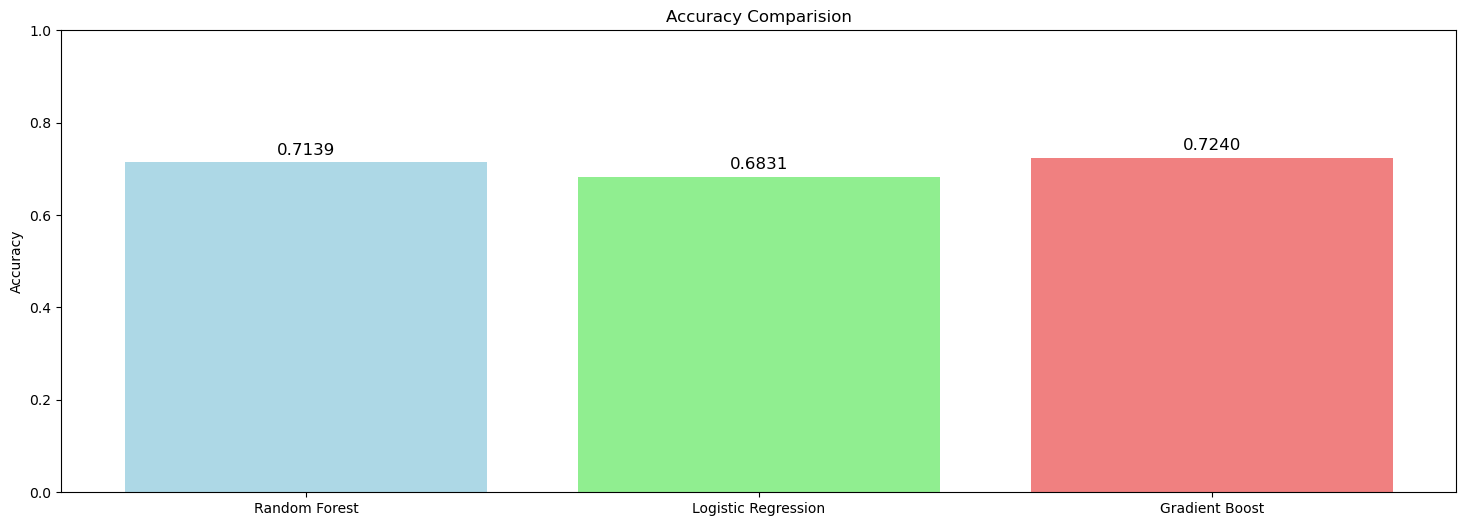

In [12]:
plt.figure(figsize=(18,6))
models = ['Random Forest','Logistic Regression','Gradient Boost']
accuracies = [accuracy_rf,accuracy_lr,accuracy_gb]
bars = plt.bar(models, accuracies, color=['lightblue', 'lightgreen', 'lightcoral'])
plt.ylabel('Accuracy')
plt.title('Accuracy Comparision')
plt.ylim(0,1)
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{accuracy:.4f}', ha='center', va='bottom', fontsize=12)
plt.show()

                 feature  importance
4                energia    0.223613
2               potencia    0.172160
6   WORKSTATION_CPU_TEMP    0.140786
9        WORKSTATION_RAM    0.135850
1              corriente    0.110883
8   WORKSTATION_GPU_TEMP    0.056256
10                  hour    0.050146
5             ESP32_temp    0.038607
0                voltaje    0.034214
3             frecuencia    0.020455
7        WORKSTATION_GPU    0.013101
11            is_weekend    0.003928


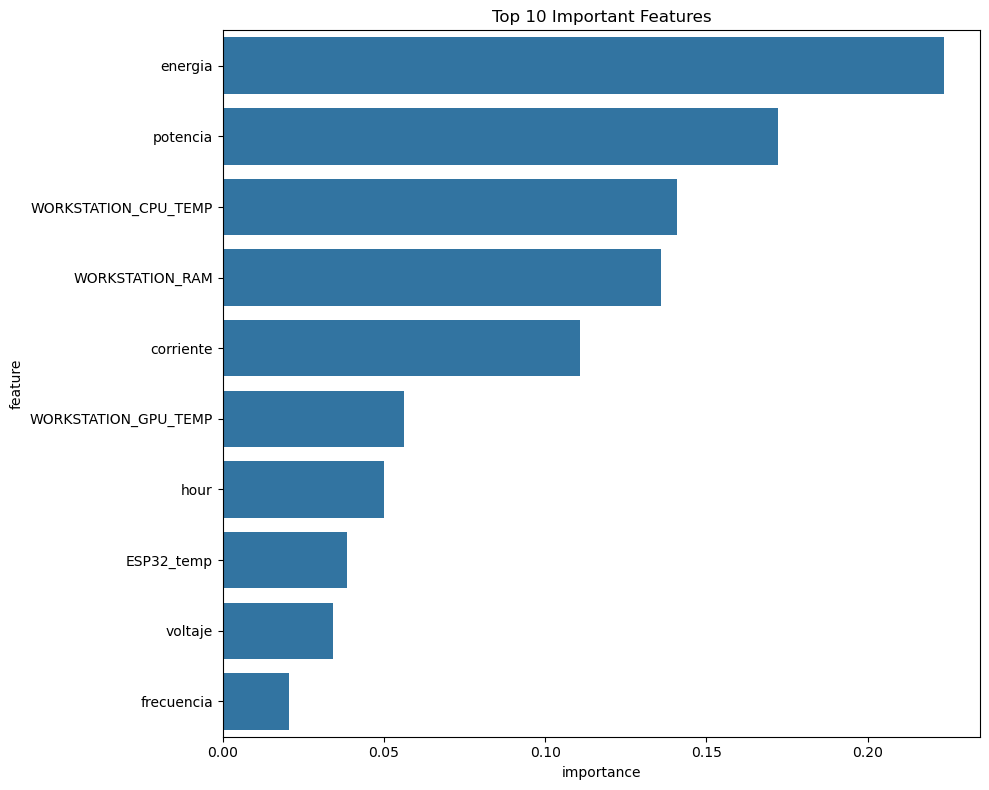

In [13]:
#Feature Importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance)

#Visualization
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Important Features')
plt.tight_layout()
plt.show()

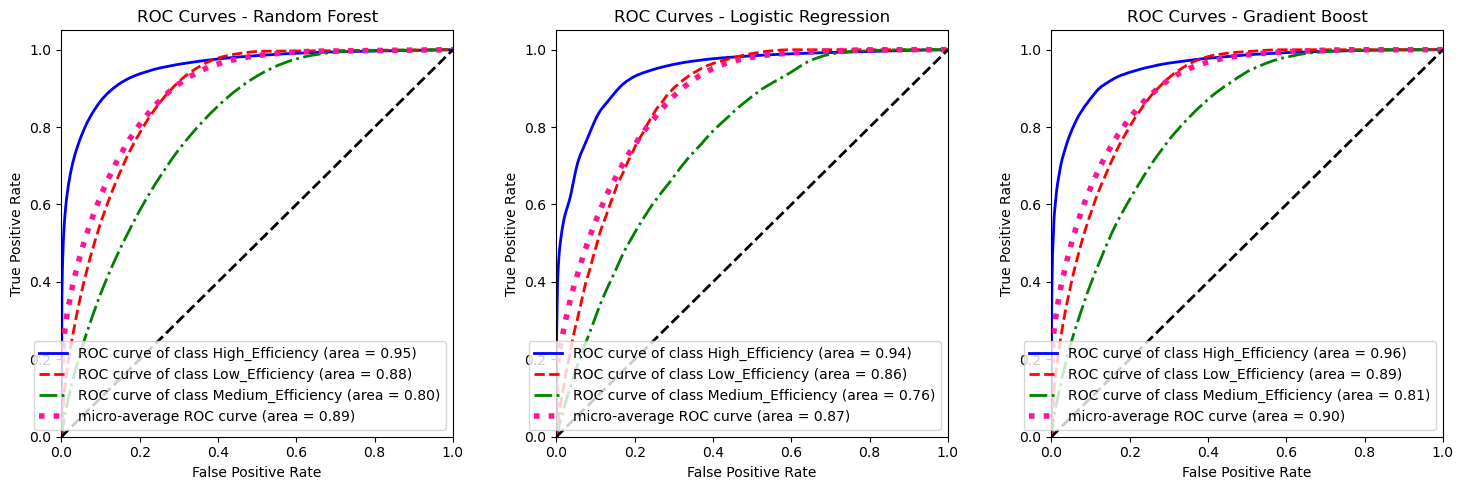

<Figure size 1000x800 with 0 Axes>

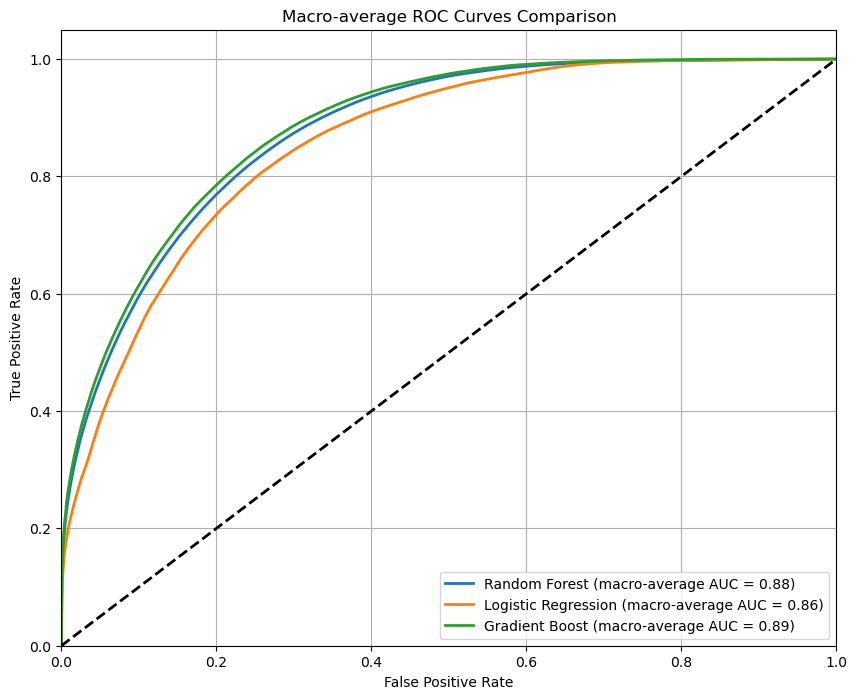

Model AUC:
Random Forest:
Micro Average AUC: 0.8940
Macro Average AUC: 0.8779
Logistic Regression:
Micro Average AUC: 0.8747
Macro Average AUC: 0.8569
Gradient Boost:
Micro Average AUC: 0.9010
Macro Average AUC: 0.8855


In [14]:
#AUC ROC
rf_proba = rf_model.predict_proba(X_test)
lr_proba = lr_model.predict_proba(X_test_scaled)
gb_proba = gb_model.predict_proba(X_test)

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

colors = cycle(['blue', 'red', 'green'])
linestyles = cycle(['-', '--', '-.'])
plt.figure(figsize=(15, 5))
models = ['Random Forest', 'Logistic Regression', 'Gradient Boost']
probabilities = [rf_proba, lr_proba, gb_proba]
for i, (model_name, y_score) in enumerate(zip(models, probabilities)):
    plt.subplot(1, 3, i+1)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], y_score[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    for j, color, linestyle in zip(range(n_classes), colors, linestyles):
        plt.plot(fpr[j], tpr[j], color=color, linestyle=linestyle, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(le.classes_[j], roc_auc[j]))
    
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
             ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {model_name}')
    plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 8))

for i, (model_name, y_score) in enumerate(zip(models, probabilities)):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], y_score[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
    mean_tpr = np.zeros_like(all_fpr)
    for j in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[j], tpr[j])
    
    mean_tpr /= n_classes
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    plt.plot(fpr["macro"], tpr["macro"],
             label='{0} (macro-average AUC = {1:0.2f})'.format(model_name, roc_auc["macro"]),
             lw=2)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curves Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("Model AUC:")
for i, (model_name, y_score) in enumerate(zip(models, probabilities)):
    fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    
    fpr = dict()
    tpr = dict()
    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], y_score[:, j])
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for j in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[j], tpr[j])
    mean_tpr /= n_classes
    auc_macro = auc(all_fpr, mean_tpr)
    
    print(f"{model_name}:")
    print(f"Micro Average AUC: {auc_micro:.4f}")
    print(f"Macro Average AUC: {auc_macro:.4f}")